In [1]:
import pandas as pd
from neo4j import GraphDatabase

In [2]:
user = "neo4j"
password = "5842Liew"
driver = GraphDatabase.driver("bolt://localhost:7687", auth=(user, password))

### 1. Graph Creation

We will start by creating our graph of products and customers in the database. The amount relationship property represents the average weekly amount of money spent by a customer on a given product.

In [3]:
create_graph_query = """
CREATE
 (dan:Person {name: 'Dan'}),
 (annie:Person {name: 'Annie'}),
 (matt:Person {name: 'Matt'}),
 (jeff:Person {name: 'Jeff'}),
 (brie:Person {name: 'Brie'}),
 (elsa:Person {name: 'Elsa'}),

 (cookies:Product {name: 'Cookies'}),
 (tomatoes:Product {name: 'Tomatoes'}),
 (cucumber:Product {name: 'Cucumber'}),
 (celery:Product {name: 'Celery'}),
 (kale:Product {name: 'Kale'}),
 (milk:Product {name: 'Milk'}),
 (chocolate:Product {name: 'Chocolate'}),

 (dan)-[:BUYS {amount: 1.2}]->(cookies),
 (dan)-[:BUYS {amount: 3.2}]->(milk),
 (dan)-[:BUYS {amount: 2.2}]->(chocolate),

 (annie)-[:BUYS {amount: 1.2}]->(cucumber),
 (annie)-[:BUYS {amount: 3.2}]->(milk),
 (annie)-[:BUYS {amount: 3.2}]->(tomatoes),

 (matt)-[:BUYS {amount: 3}]->(tomatoes),
 (matt)-[:BUYS {amount: 2}]->(kale),
 (matt)-[:BUYS {amount: 1}]->(cucumber),

 (jeff)-[:BUYS {amount: 3}]->(cookies),
 (jeff)-[:BUYS {amount: 2}]->(milk),

 (brie)-[:BUYS {amount: 1}]->(tomatoes),
 (brie)-[:BUYS {amount: 2}]->(milk),
 (brie)-[:BUYS {amount: 2}]->(kale),
 (brie)-[:BUYS {amount: 3}]->(cucumber),
 (brie)-[:BUYS {amount: 0.3}]->(celery),

 (elsa)-[:BUYS {amount: 3}]->(chocolate),
 (elsa)-[:BUYS {amount: 3}]->(milk);
 """

In [4]:
with driver.session() as session:
    session.run(create_graph_query)

Create in-memory graph which we can run the graph algorithms on.

In [5]:
create_memory_graph_query = """
CALL gds.graph.create(
  'purchases',
  ['Person','Product'],
  {
    BUYS: {
      orientation: 'UNDIRECTED',
      properties: 'amount'
    }
  }
)
"""

In [6]:
with driver.session() as session:
    session.run(create_memory_graph_query)

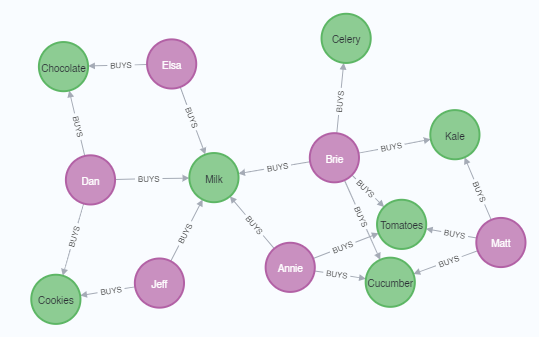

### 2. Fast RP Embedding

Run the FastRP algorithm to generate node embeddings that capture topological information from the graph. We choose to work with 'embeddingDimension' set to 4 which is sufficient since the example graph is very small. The 'iterationWeights' are chosen empirically to yield sensible results. Since we want to use the embeddings as input when we run kNN later we use FastRP’s 'mutate' mode.

In [7]:
fastRP_query = """
CALL gds.fastRP.mutate('purchases',
{
    embeddingDimension: 4,
    randomSeed: 42, 
    mutateProperty: 'embedding',
    relationshipWeightProperty: 'amount',
    iterationWeights: [0.8,1,1,1]
})
YIELD nodePropertiesWritten
"""

In [8]:
with driver.session() as session:
    rows = session.run(fastRP_query)
    fastRP_df = pd.DataFrame([dict(record) for record in rows])

In [9]:
fastRP_df

,nodePropertiesWritten
0,13


### 3. Similarity with kNN

Now we can run kNN to identify similar nodes by using the node embeddings that we generated with FastRP as 'nodeWeightProperty'. Since we are working with a small graph, we can set 'sampleRate' to 1 and 'deltaThreshold' to 0 without having to worry about long computation times. The concurrency parameter is set to 1 (along with the fixed randomSeed) in order to get a deterministic result. Please see the syntax section of the kNN documentation for more information on these parameters. Note that we use the algorithm’s 'write' mode to write the properties and relationships back to our database, so that we can analyze them later using Cypher.

In [10]:
knn_query = """
CALL gds.beta.knn.write('purchases', {
    topK: 2, 
    nodeWeightProperty: 'embedding',
    randomSeed: 42, 
    concurrency: 1,
    sampleRate: 1.0, 
    deltaThreshold: 0.0, 
    writeRelationshipType: "SIMILAR",
    writeProperty: "score"
})
YIELD nodesCompared, relationshipsWritten, similarityDistribution
RETURN nodesCompared, relationshipsWritten, similarityDistribution.mean AS meanSimilarity
"""

In [11]:
with driver.session() as session:
    rows = session.run(knn_query)
    knn_df = pd.DataFrame([dict(record) for record in rows])

In [12]:
knn_df

,nodesCompared,relationshipsWritten,meanSimilarity
0,13,26,0.978536


The mean similarity between nodes is pretty high. This is due to the fact that the example graph is small where there are no long paths between nodes leading to many similar FastRP node embeddings.

### 4. Results Exploration

Let us now inspect the results of our kNN call by using Cypher. We can use the 'SIMILARITY' relationship type to filter out the relationships we are interested in. And since we just care about similarities between people for our product recommendation engine, we make sure to only match nodes with the Person label.

In [13]:
result_query = """
MATCH (n:Person)-[r:SIMILAR]->(m:Person)
RETURN n.name as person1, m.name as person2, r.score as similarity
ORDER BY similarity DESCENDING, person1, person2
"""

In [14]:
with driver.session() as session:
    rows = session.run(result_query)
    result_df = pd.DataFrame([dict(record) for record in rows])

In [15]:
result_df

,person1,person2,similarity
0,Dan,Elsa,0.996100
1,Elsa,Dan,0.996100
2,Jeff,Dan,0.981131
3,Brie,Matt,0.977379
4,Matt,Brie,0.977379


Our kNN results indicate among other things that the Person nodes named "Dan" and "Elsa" are very similar. Looking at the BUYS relationships for these two nodes we can see that such a conclusion makes sense. Dan bought cookies, chocolate, and milk while Elsa bought chocolate and milk. Two of the products are the same.

### 5. Making Recommendations

Using the information we derived that the Person nodes named "Dan" and "Elsa" are similar, we can make product recommendations for each of them. Since they are similar, we can assume that products purchased by only one of the people may be of interest to buy also for the other person not already buying the product. By this principle we can derive product recommendations for the Person named "Elsa" using a simple Cypher query.

In [19]:
recom_query = """
MATCH (:Person {name: "Elsa"})-->(p1:Product)
WITH collect(p1) as products
MATCH (:Person {name: "Dan"})-->(p2:Product)
WHERE not p2 in products
RETURN p2.name as recommendation
"""

In [20]:
with driver.session() as session:
    rows = session.run(recom_query)
    recom_df = pd.DataFrame([dict(record) for record in rows])

In [21]:
recom_df

,recommendation
0,Cookies


Elsa is recommended to purchase cookies. 